### generalization test
use different data set to test the trained network

In [1]:
item = 'random_best_3'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.io as scio
import torch
import torch.nn as nn
from torchinfo import summary
from timeit import default_timer
import sys
sys.path.append("../scripts/")
sys.path.append("../run/")
import yaml
from utilities import *
from deeponet_2d import *
# from fourier_2d import *
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

### plot parameters

In [3]:
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize']  = 16
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams['image.cmap'] = 'jet_r'

In [4]:
with open( '../run/config.yml') as f:
    config = yaml.full_load(f)
config = config[item]
device = torch.device('cpu')
TRAIN_PATH = config['TRAIN_PATH']
TEST_PATH  = config['TEST_PATH']
save_mode  = config['save_mode']
n_out      = config['n_out'] # rhoxy,phsxy,rhoyx,phsyx
model_path = "../temp/"+config['name']+ "_"+str(n_out) # save path and name of model
model_path_temp = "../temp/"+config['name']+"_"+ str(n_out)
log_path = "../Log/"+config['name']+"_"+str(n_out)+'.log'

ntrain = config['ntrain']
ntest  = config['ntest']

batch_size = config['batch_size']
learning_rate = config['learning_rate']

epochs = config['epochs']
step_size = config['step_size']
gamma = config['gamma']

modes = config['modes']
width = config['width']

s_train = config['s_train']
r_train = config['r_train']
s_test = config['s_test']
r_test = config['r_test']
layer_num = config['layer_num']
last_size = config['last_size'] 
act_fno   = config['act_fno']

layer_sizes = config['layer_sizes']+[s_train[0]*s_train[1]]
act_func  = config['act_func']
init_func = config['init_func']
    

patience = config['patience'] # if there is {patience} epoch that val_error is larger, early stop,
thre_epoch = config['thre_epoch']# condiser early stop after {thre_epoch} epochs

print_model_flag = config['print_model_flag'] # 

In [5]:
if os.path.exists(model_path+'.pt'):
    model=torch.load(model_path+'.pt',map_location=device)
elif os.path.exists(model_path+'.pkl'):
    model=deeponet(layer_sizes, act_func, init_func,modes, modes, width,\
        n_out,layer_num, last_size, act_fno).to(device)
    model.load_state_dict(torch.load(model_path+'.pkl',map_location=device))
else:
    raise RuntimeError('no model file')
myloss = LpLoss(size_average=False)

In [6]:
def error_r(x1,x0):
    '''relative error 
    x1 : prediction
    x0 : exact
    '''
    return np.linalg.norm(x1-x0)/np.linalg.norm(x0)

### 0. standard data set

In [7]:
loc_train,loc_test,train_loader, test_loader, x_normalizer,y_normalizer = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]

begin to read data
reading finished in 14.387 s


### 1. alpha = 3

In [8]:
# ntrain = ntest
# TRAIN_PATH = "../../Data/data/test_random_alpha3_coarse.mat"
TEST_PATH  = "../../Data/data/test_alpha_3_3000_0.mat"
loc_train,loc_test,train_loader, test_loader, x_normalizer,y_normalizer = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]

begin to read data
reading finished in 11.828 s


In [9]:
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        out = model(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y.shape[-1]
        out = torch.cat(([out[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out = y_normalizer.decode(out)

        test_l2 += myloss(out, y).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

33.74069452192634 0.006506450583537419


Relative rhoxy,rhoyx, phsxy,phsyx error:  0.009070096 0.012843214 0.020885741 0.024639994


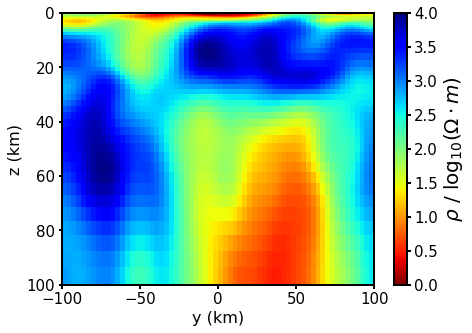

In [10]:
i = 8

a_cof = x_normalizer.decode(x)[i, ..., 0].cpu().numpy()
a_cof = np.log10(1/(10**a_cof))
rhoxy = out[i, ...,0].cpu().numpy()
phsxy = out[i, ...,1].cpu().numpy()
rhoyx = out[i, ...,2].cpu().numpy()
phsyx = out[i, ...,3].cpu().numpy()-180
rhoxy_true = y[i, ...,0].cpu().numpy()
phsxy_true = y[i, ...,1].cpu().numpy()
rhoyx_true = y[i, ...,2].cpu().numpy()
phsyx_true = y[i, ...,3].cpu().numpy()-180

print("Relative rhoxy,rhoyx, phsxy,phsyx error: ", \
     error_r(rhoxy,rhoxy_true),error_r(rhoyx,rhoyx_true),error_r(phsxy,phsxy_true),error_r(phsyx,phsyx_true),)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
h=ax.pcolormesh(yn/1e3,zn/1e3,a_cof, vmin=0,vmax=4,shading='flat')#,edgecolors='k')
ax.set_xlabel('y (km)')
ax.set_ylabel('z (km)')
ax.invert_yaxis()
cbar = fig.colorbar(h)
cbar.set_label(r"$\rho$ / $\log_{10}(\Omega\cdot m)$",fontsize=20)# ax = plt.subplot(3,2,2)

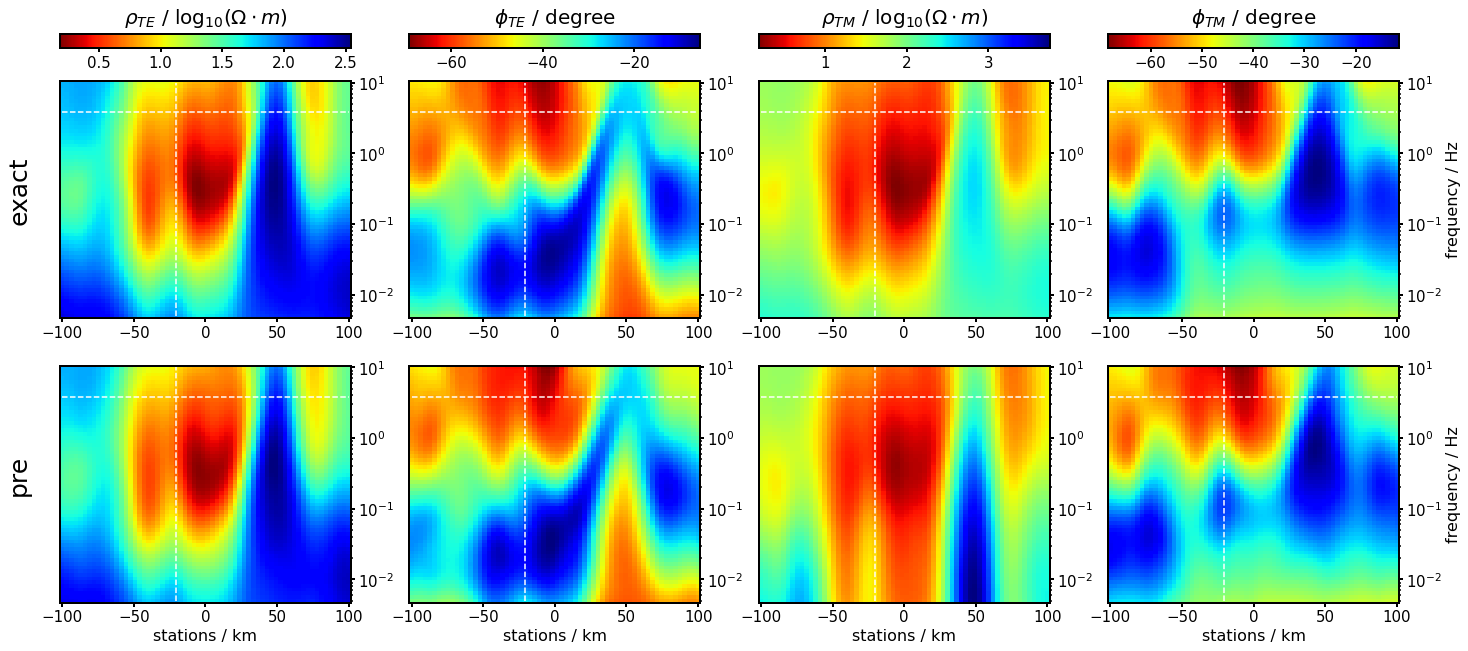

In [11]:
obs_id = 25# idx of frequency
f_id = 8# idx of frequency
id_f = 40

n_row,n_column = 2, 4
figsize   = (6*n_column,6*n_row)
pad            = 0.05 # pad between colorbar and map (value is relative to figsize?)   
labelpad       = 10 # label pad between label and bar (value is relative to axis value?)  
text_size      = 25 # text size
bar_size       = 20 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'top' # colorbar location relative to map
text_x_pos     = -130 # text location (value is relative to axis data in map)
text_y_pos     = 0.3 
rotation       = 90  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.


bar_label = [r'$\rho_{TE}$ / $\log_{10}(\Omega\cdot m)$',r'$\phi_{TE}$ / degree',\
             r'$\rho_{TM}$ / $\log_{10}(\Omega\cdot m)$',r'$\phi_{TM}$ / degree']
x_label   = 'stations / km'
y_label   = 'frequency / Hz'

data = [[rhoxy_true,rhoxy],
        [phsxy_true,phsxy],
        [rhoxy_true,rhoyx],
        [phsyx_true,phsyx]
        ]

norm_rhoxy = colors.Normalize(vmin=np.min(data[0]),vmax=np.max(data[0]))
norm_phsxy = colors.Normalize(vmin=np.min(data[1]),vmax=np.max(data[1]))
norm_rhoyx = colors.Normalize(vmin=np.min(data[2]),vmax=np.max(data[2]))
norm_phsyx = colors.Normalize(vmin=np.min(data[3]),vmax=np.max(data[3]))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]
title_out = ['exact','pre']

ry_row      = [ry[obs_id]/1e3,ry[obs_id]/1e3]
ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_row    = [np.min(freq),np.max(freq)]
freq_column = [freq[f_id],freq[f_id]]

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        h = ax[i,j].pcolormesh(ry/1e3,freq,data[j][i],norm=norm[j], shading=shading)
        ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
        ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        ax[i,j].set_yscale("log")
        
        if j == 0:
            ax[i,j].text(text_x_pos,text_y_pos,title_out[i], horizontalalignment='center',\
                         verticalalignment='center',rotation=rotation,fontsize=text_size)
        ax[i,j].yaxis.tick_right()
        ax[i,j].yaxis.set_label_position("right")
        if j == n_column-1:
            ax[i,j].set_ylabel(y_label)
    ax[i,j].set_xlabel(x_label)
    cbar = fig.colorbar(h,ax=[ax[ii,j] for ii in range(n_row)],location=loc,pad=pad)
    cbar.set_label(bar_label[j],fontsize=bar_size,labelpad=labelpad)
    cbar.ax.xaxis.set_ticks_position(ticks_position)

plt.show()

### 3. alpha = 4

In [12]:
TEST_PATH  = "../../Data/data/test_alpha_4_3000_0.mat"
_,loc_test_2,_, test_loader_2, _,_ = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
t1 = default_timer()
loc_test_2 = loc_test_2.to(device)
with torch.no_grad():
    for x_2, y_2 in test_loader_2:
        x_2, y_2 = x_2.to(device), y_2.to(device)

        out_2 = model(loc_test_2,x_2)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y_2.shape[-1]
        out_2 = torch.cat(([out_2[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out_2 = y_normalizer.decode(out_2)

        test_l2 += myloss(out_2, y_2).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

begin to read data
reading finished in 10.626 s
31.663225408643484 0.004209895427028338


Relative rhoxy,rhoyx, phsxy,phsyx error:  0.0021724298 0.0035439976 0.006127586 0.0063463286


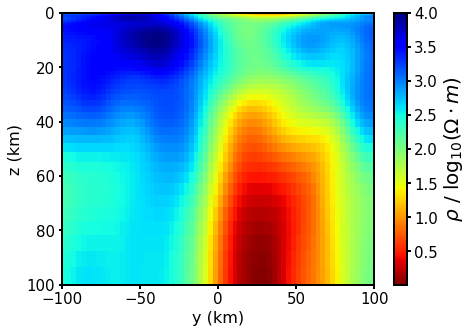

In [13]:
i = 1

a_cof_2 = x_normalizer.decode(x_2)[i, ..., 0].cpu().numpy()
a_cof_2 = np.log10(1/(10**a_cof_2))
rhoxy_2    = out_2[i, ...,0].cpu().numpy()
phsxy_2    = out_2[i, ...,1].cpu().numpy()
rhoyx_2    = out_2[i, ...,2].cpu().numpy()
phsyx_2    = out_2[i, ...,3].cpu().numpy()-180
rhoxy_2_true = y_2[i, ...,0].cpu().numpy()
phsxy_2_true = y_2[i, ...,1].cpu().numpy()
rhoyx_2_true = y_2[i, ...,2].cpu().numpy()
phsyx_2_true = y_2[i, ...,3].cpu().numpy()-180

print("Relative rhoxy,rhoyx, phsxy,phsyx error: ", \
     error_r(rhoxy_2,rhoxy_2_true),error_r(rhoyx_2,rhoyx_2_true),error_r(phsxy_2,phsxy_2_true),error_r(phsyx_2,phsyx_2_true),)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
h=ax.pcolormesh(yn/1e3,zn/1e3,a_cof_2, shading='flat')#,edgecolors='k')
ax.set_xlabel('y (km)')
ax.set_ylabel('z (km)')
ax.invert_yaxis()
cbar = fig.colorbar(h)
cbar.set_label(r"$\rho$ / $\log_{10}(\Omega\cdot m)$",fontsize=20)# ax = plt.subplot(3,2,2)

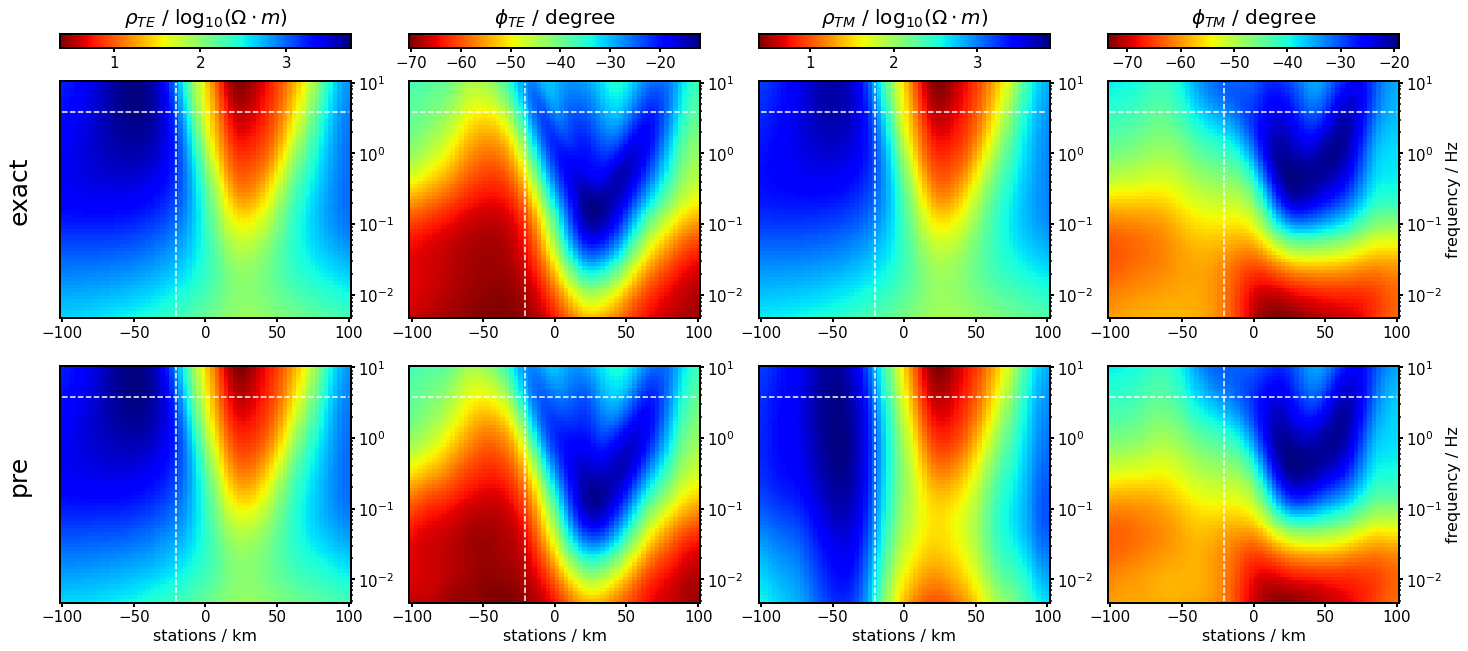

In [14]:
obs_id = 25# idx of frequency
f_id = 8# idx of frequency
id_f = 40

n_row,n_column = 2, 4
figsize   = (6*n_column,6*n_row)
pad            = 0.05 # pad between colorbar and map (value is relative to figsize?)   
labelpad       = 10 # label pad between label and bar (value is relative to axis value?)  
text_size      = 25 # text size
bar_size       = 20 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'top' # colorbar location relative to map
text_x_pos     = -130 # text location (value is relative to axis data in map)
text_y_pos     = 0.3 
rotation       = 90  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.


bar_label = [r'$\rho_{TE}$ / $\log_{10}(\Omega\cdot m)$',r'$\phi_{TE}$ / degree',\
             r'$\rho_{TM}$ / $\log_{10}(\Omega\cdot m)$',r'$\phi_{TM}$ / degree']
x_label   = 'stations / km'
y_label   = 'frequency / Hz'

data = [[rhoxy_2_true,rhoxy_2],
        [phsxy_2_true,phsxy_2],
        [rhoxy_2_true,rhoyx_2],
        [phsyx_2_true,phsyx_2]
        ]

norm_rhoxy = colors.Normalize(vmin=np.min(data[0]),vmax=np.max(data[0]))
norm_phsxy = colors.Normalize(vmin=np.min(data[1]),vmax=np.max(data[1]))
norm_rhoyx = colors.Normalize(vmin=np.min(data[2]),vmax=np.max(data[2]))
norm_phsyx = colors.Normalize(vmin=np.min(data[3]),vmax=np.max(data[3]))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]
title_out = ['exact','pre']

ry_row      = [ry[obs_id]/1e3,ry[obs_id]/1e3]
ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_row    = [np.min(freq),np.max(freq)]
freq_column = [freq[f_id],freq[f_id]]

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        h = ax[i,j].pcolormesh(ry/1e3,freq,data[j][i],norm=norm[j], shading=shading)
        ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
        ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        ax[i,j].set_yscale("log")
        
        if j == 0:
            ax[i,j].text(text_x_pos,text_y_pos,title_out[i], horizontalalignment='center',\
                         verticalalignment='center',rotation=rotation,fontsize=text_size)
        ax[i,j].yaxis.tick_right()
        ax[i,j].yaxis.set_label_position("right")
        if j == n_column-1:
            ax[i,j].set_ylabel(y_label)
    ax[i,j].set_xlabel(x_label)
    cbar = fig.colorbar(h,ax=[ax[ii,j] for ii in range(n_row)],location=loc,pad=pad)
    cbar.set_label(bar_label[j],fontsize=bar_size,labelpad=labelpad)
    cbar.ax.xaxis.set_ticks_position(ticks_position)

plt.show()

### alpha = 5

In [15]:
TEST_PATH  = "../../Data/data/test_alpha_5_3000_0.mat"
_,loc_test_2,_, test_loader_2, _,_ = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
t1 = default_timer()
loc_test_2 = loc_test_2.to(device)
with torch.no_grad():
    for x_2, y_2 in test_loader_2:
        x_2, y_2 = x_2.to(device), y_2.to(device)

        out_2 = model(loc_test_2,x_2)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y_2.shape[-1]
        out_2 = torch.cat(([out_2[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out_2 = y_normalizer.decode(out_2)

        test_l2 += myloss(out_2, y_2).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

begin to read data
reading finished in 10.461 s
31.87808213289827 0.0031530327598253884


Relative rhoxy,rhoyx, phsxy,phsyx error:  0.0031228468 0.004360832 0.010213624 0.010548015


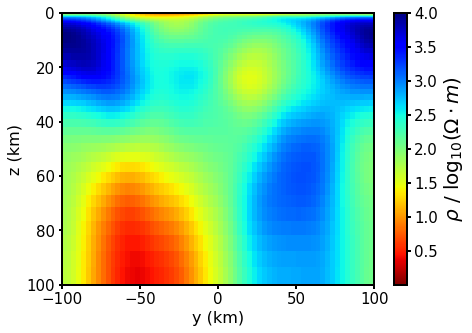

In [16]:
i = 1

a_cof_2 = x_normalizer.decode(x_2)[i, ..., 0].cpu().numpy()
a_cof_2 = np.log10(1/(10**a_cof_2))
rhoxy_2    = out_2[i, ...,0].cpu().numpy()
phsxy_2    = out_2[i, ...,1].cpu().numpy()
rhoyx_2    = out_2[i, ...,2].cpu().numpy()
phsyx_2    = out_2[i, ...,3].cpu().numpy()-180
rhoxy_2_true = y_2[i, ...,0].cpu().numpy()
phsxy_2_true = y_2[i, ...,1].cpu().numpy()
rhoyx_2_true = y_2[i, ...,2].cpu().numpy()
phsyx_2_true = y_2[i, ...,3].cpu().numpy()-180

print("Relative rhoxy,rhoyx, phsxy,phsyx error: ", \
     error_r(rhoxy_2,rhoxy_2_true),error_r(rhoyx_2,rhoyx_2_true),error_r(phsxy_2,phsxy_2_true),error_r(phsyx_2,phsyx_2_true),)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
h=ax.pcolormesh(yn/1e3,zn/1e3,a_cof_2, shading='flat')#,edgecolors='k')
ax.set_xlabel('y (km)')
ax.set_ylabel('z (km)')
ax.invert_yaxis()
cbar = fig.colorbar(h)
cbar.set_label(r"$\rho$ / $\log_{10}(\Omega\cdot m)$",fontsize=20)# ax = plt.subplot(3,2,2)

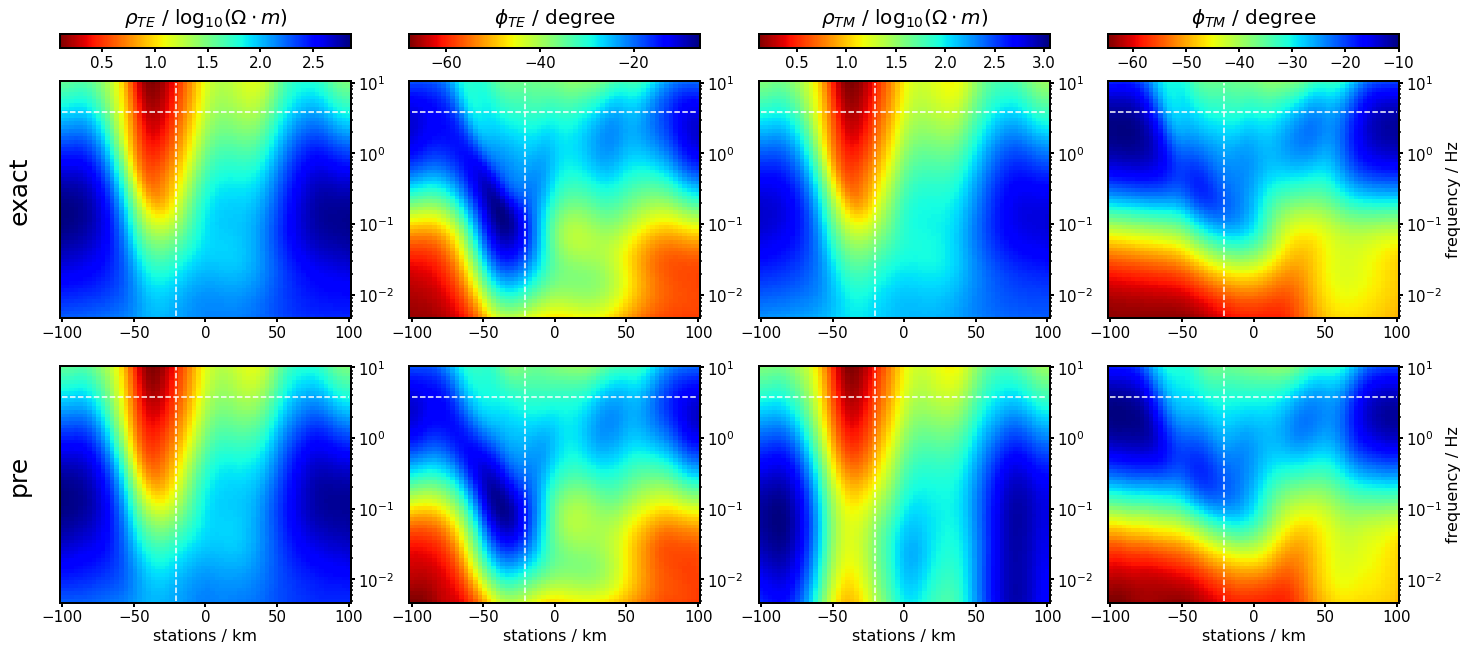

In [17]:
obs_id = 25# idx of frequency
f_id = 8# idx of frequency
id_f = 40

n_row,n_column = 2, 4
figsize   = (6*n_column,6*n_row)
pad            = 0.05 # pad between colorbar and map (value is relative to figsize?)   
labelpad       = 10 # label pad between label and bar (value is relative to axis value?)  
text_size      = 25 # text size
bar_size       = 20 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'top' # colorbar location relative to map
text_x_pos     = -130 # text location (value is relative to axis data in map)
text_y_pos     = 0.3 
rotation       = 90  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.


bar_label = [r'$\rho_{TE}$ / $\log_{10}(\Omega\cdot m)$',r'$\phi_{TE}$ / degree',\
             r'$\rho_{TM}$ / $\log_{10}(\Omega\cdot m)$',r'$\phi_{TM}$ / degree']
x_label   = 'stations / km'
y_label   = 'frequency / Hz'

data = [[rhoxy_2_true,rhoxy_2],
        [phsxy_2_true,phsxy_2],
        [rhoxy_2_true,rhoyx_2],
        [phsyx_2_true,phsyx_2]
        ]

norm_rhoxy = colors.Normalize(vmin=np.min(data[0]),vmax=np.max(data[0]))
norm_phsxy = colors.Normalize(vmin=np.min(data[1]),vmax=np.max(data[1]))
norm_rhoyx = colors.Normalize(vmin=np.min(data[2]),vmax=np.max(data[2]))
norm_phsyx = colors.Normalize(vmin=np.min(data[3]),vmax=np.max(data[3]))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]
title_out = ['exact','pre']

ry_row      = [ry[obs_id]/1e3,ry[obs_id]/1e3]
ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_row    = [np.min(freq),np.max(freq)]
freq_column = [freq[f_id],freq[f_id]]

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        h = ax[i,j].pcolormesh(ry/1e3,freq,data[j][i],norm=norm[j], shading=shading)
        ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
        ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        ax[i,j].set_yscale("log")
        
        if j == 0:
            ax[i,j].text(text_x_pos,text_y_pos,title_out[i], horizontalalignment='center',\
                         verticalalignment='center',rotation=rotation,fontsize=text_size)
        ax[i,j].yaxis.tick_right()
        ax[i,j].yaxis.set_label_position("right")
        if j == n_column-1:
            ax[i,j].set_ylabel(y_label)
    ax[i,j].set_xlabel(x_label)
    cbar = fig.colorbar(h,ax=[ax[ii,j] for ii in range(n_row)],location=loc,pad=pad)
    cbar.set_label(bar_label[j],fontsize=bar_size,labelpad=labelpad)
    cbar.ax.xaxis.set_ticks_position(ticks_position)

plt.show()

### alpha =6

In [22]:
TEST_PATH  = "../../Data/data/test_alpha_6_3000_0.mat"
_,loc_test_2,_, test_loader_2, _,_ = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
t1 = default_timer()
loc_test_2 = loc_test_2.to(device)
with torch.no_grad():
    for x_2, y_2 in test_loader_2:
        x_2, y_2 = x_2.to(device), y_2.to(device)

        out_2 = model(loc_test_2,x_2)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y_2.shape[-1]
        out_2 = torch.cat(([out_2[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out_2 = y_normalizer.decode(out_2)

        test_l2 += myloss(out_2, y_2).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

begin to read data
reading finished in 11.956 s
37.55962920188904 0.0026859068249662716


Relative rhoxy,rhoyx, phsxy,phsyx error:  0.00579447 0.008215495 0.011088098 0.011887314


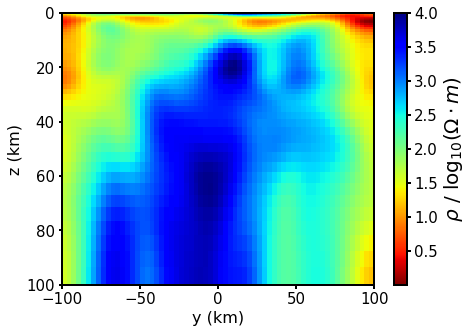

In [19]:
i = 1

a_cof_2 = x_normalizer.decode(x_2)[i, ..., 0].cpu().numpy()
a_cof_2 = np.log10(1/(10**a_cof_2))
rhoxy_2    = out_2[i, ...,0].cpu().numpy()
phsxy_2    = out_2[i, ...,1].cpu().numpy()
rhoyx_2    = out_2[i, ...,2].cpu().numpy()
phsyx_2    = out_2[i, ...,3].cpu().numpy()-180
rhoxy_2_true = y_2[i, ...,0].cpu().numpy()
phsxy_2_true = y_2[i, ...,1].cpu().numpy()
rhoyx_2_true = y_2[i, ...,2].cpu().numpy()
phsyx_2_true = y_2[i, ...,3].cpu().numpy()-180

print("Relative rhoxy,rhoyx, phsxy,phsyx error: ", \
     error_r(rhoxy_2,rhoxy_2_true),error_r(rhoyx_2,rhoyx_2_true),error_r(phsxy_2,phsxy_2_true),error_r(phsyx_2,phsyx_2_true),)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
h=ax.pcolormesh(yn/1e3,zn/1e3,a_cof_2, shading='flat')#,edgecolors='k')
ax.set_xlabel('y (km)')
ax.set_ylabel('z (km)')
ax.invert_yaxis()
cbar = fig.colorbar(h)
cbar.set_label(r"$\rho$ / $\log_{10}(\Omega\cdot m)$",fontsize=20)# ax = plt.subplot(3,2,2)

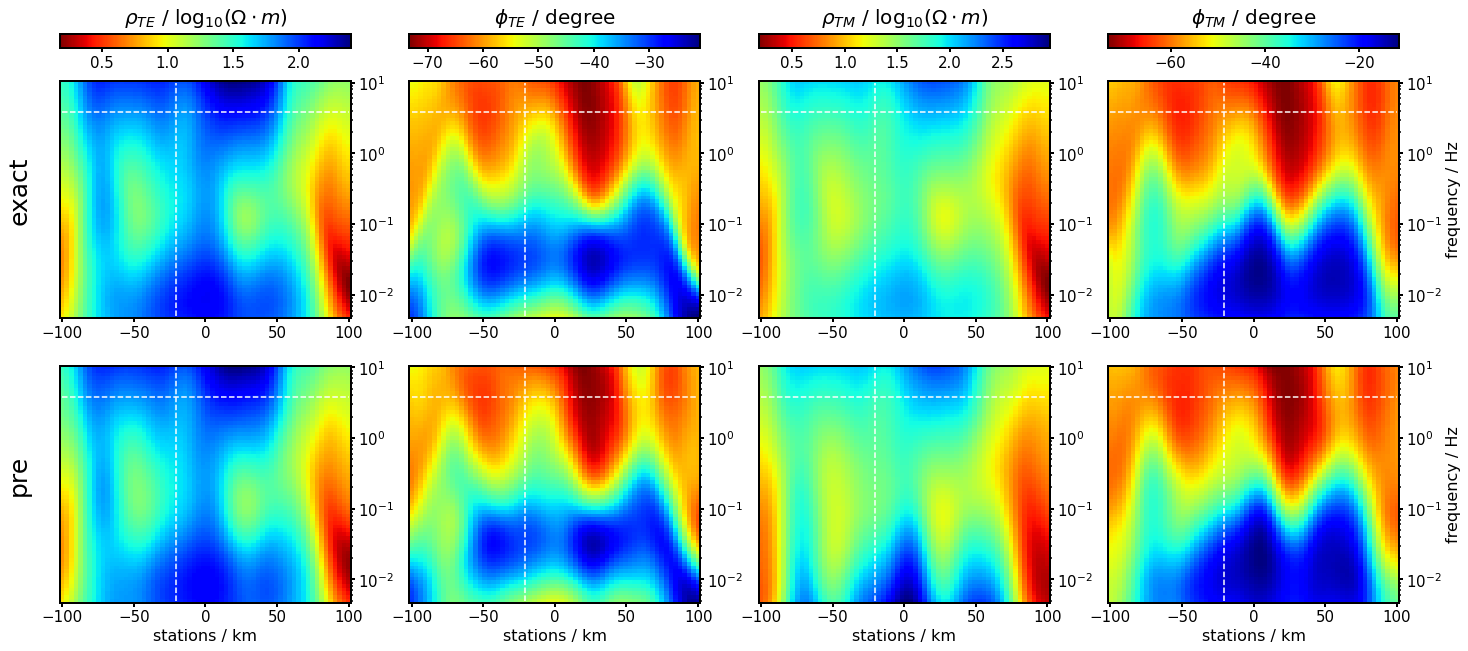

In [20]:
obs_id = 25# idx of frequency
f_id = 8# idx of frequency
id_f = 40

n_row,n_column = 2, 4
figsize   = (6*n_column,6*n_row)
pad            = 0.05 # pad between colorbar and map (value is relative to figsize?)   
labelpad       = 10 # label pad between label and bar (value is relative to axis value?)  
text_size      = 25 # text size
bar_size       = 20 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'top' # colorbar location relative to map
text_x_pos     = -130 # text location (value is relative to axis data in map)
text_y_pos     = 0.3 
rotation       = 90  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.


bar_label = [r'$\rho_{TE}$ / $\log_{10}(\Omega\cdot m)$',r'$\phi_{TE}$ / degree',\
             r'$\rho_{TM}$ / $\log_{10}(\Omega\cdot m)$',r'$\phi_{TM}$ / degree']
x_label   = 'stations / km'
y_label   = 'frequency / Hz'

data = [[rhoxy_2_true,rhoxy_2],
        [phsxy_2_true,phsxy_2],
        [rhoxy_2_true,rhoyx_2],
        [phsyx_2_true,phsyx_2]
        ]

norm_rhoxy = colors.Normalize(vmin=np.min(data[0]),vmax=np.max(data[0]))
norm_phsxy = colors.Normalize(vmin=np.min(data[1]),vmax=np.max(data[1]))
norm_rhoyx = colors.Normalize(vmin=np.min(data[2]),vmax=np.max(data[2]))
norm_phsyx = colors.Normalize(vmin=np.min(data[3]),vmax=np.max(data[3]))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]
title_out = ['exact','pre']

ry_row      = [ry[obs_id]/1e3,ry[obs_id]/1e3]
ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_row    = [np.min(freq),np.max(freq)]
freq_column = [freq[f_id],freq[f_id]]

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        h = ax[i,j].pcolormesh(ry/1e3,freq,data[j][i],norm=norm[j], shading=shading)
        ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
        ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        ax[i,j].set_yscale("log")
        
        if j == 0:
            ax[i,j].text(text_x_pos,text_y_pos,title_out[i], horizontalalignment='center',\
                         verticalalignment='center',rotation=rotation,fontsize=text_size)
        ax[i,j].yaxis.tick_right()
        ax[i,j].yaxis.set_label_position("right")
        if j == n_column-1:
            ax[i,j].set_ylabel(y_label)
    ax[i,j].set_xlabel(x_label)
    cbar = fig.colorbar(h,ax=[ax[ii,j] for ii in range(n_row)],location=loc,pad=pad)
    cbar.set_label(bar_label[j],fontsize=bar_size,labelpad=labelpad)
    cbar.ax.xaxis.set_ticks_position(ticks_position)

plt.show()

### alpha=7

In [21]:
TEST_PATH  = "../../Data/data/test_alpha_7_3000_0.mat"
_,loc_test_2,_, test_loader_2, _,_ = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
t1 = default_timer()
loc_test_2 = loc_test_2.to(device)
with torch.no_grad():
    for x_2, y_2 in test_loader_2:
        x_2, y_2 = x_2.to(device), y_2.to(device)

        out_2 = model(loc_test_2,x_2)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y_2.shape[-1]
        out_2 = torch.cat(([out_2[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out_2 = y_normalizer.decode(out_2)

        test_l2 += myloss(out_2, y_2).item()

test_l2 /= ntest

t2 = default_timer()
print(t2-t1, test_l2)

begin to read data
reading finished in 10.409 s
31.754482145421207 0.0024499172096451123
